UTS Deep Learning

Nomor 2

Nama: Rio Pramana

NIM: 2440016804

Kelas: LA01

Untuk penjelasan code akan diberikan melalui markdown cell dan comment pada code

**Import libraries**

In [1]:
%matplotlib inline
import numpy as np
from sklearn.metrics import classification_report

# Using tensorflow & keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Untuk keperluan directory/files
import os
import shutil # Untuk copy files

import matplotlib.pyplot as plt # Untuk visualisasi

**Upload Data**

**Please only run this if the code block below is executed in Google Colab**

**Otherwise, please ignore this code block below**

To upload data in google colab:

In [2]:
# # only run this in google colab to upload data
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

If the uploaded data is still in .zip form, then unzip it first using this code: (**this code block only works in google colab**)

(**Jika file dataset .zip sudah diextract sebelumnya, please ignore this code block below**)

In [3]:
# !unzip ASL.zip

**Please only run this if the code block below is executed in Jupyter Notebook**

**Otherwise, please ignore this code block below**

(Di jupyter notebook, kita tidak perlu mengupload data, kita cuma perlu memastikan bahwa datasetnya berada di folder yang sama dengan file .ipynb nya)

If the uploaded data is still in .zip form, then unzip it first using this code: (**this code block only works in jupyter notebook:**)

(**Jika file dataset .zip sudah diextract sebelumnya, please ignore  this code block below**)

In [4]:
# Libraries untuk unzipping di jupyter
import glob
import zipfile

files = glob.glob('ASL.zip')

for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall()

Unzipping: ASL.zip


Setting random seed dengan tujuan untuk mencoba menghasilkan hasil yang sama (agar hasil memiliki kemungkinan yang lebih tinggi untuk tidak berubah setiap kali code dijalankan sehingga lebih mudah untuk dianalisis)

In [5]:
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)

# **a. Inisialisasi hyperparameter, resize gambar, dan augmentasi data dan b. Splitting dataset menjadi 80% training 20% validation**

**Inisialisasi hyperparameter:**

In [6]:
# Karena jumlah data sangat besar, maka saya set batch_size = 512
batch_size = 512
n_features = 64 # Output features layer pertama
# Sesuai permintaan soal, program ini hanya bekerja pada alfabet
nb_classes = 26  # 26 English Alphabet letters from A to Z
# Seperti pada nomor 1, disarankan epochs = features * 3..
# ..Namun, karena nilainya terlalu besar, maka saya ubah menjadi 20
epochs = 20

# Dimensions of the input images (200x200 pixels)
img_rows, img_cols = 200, 200
resized_dim = 64 # Dimensi resized image

# Arsitektur baseline
first_kernel_size = (5, 5) # Size kernel pertama
second_kernel_size = (3, 3) # Size kernel selanjutnya

In [7]:
true_classes = [] # List untuk menyimpan classes test

Sebelum melakukan preprocessing dan splitting dataset, terdapat suatu masalah pada dataset yang diberikan

Pada folder data test, tidak terdapat subfolders sebagai indikator ground truth masing-masing image test seperti pada folder data train

Maka, untuk mempermudah pembuatan model, saya buat terlebih dahulu subfolders untuk data test (menggunakan code python):

In [8]:
if len(true_classes) == 0: # Kondisi agar code ini tidak berjalan lebih dari 1 kali
  test_data_dir = 'ALS/asl_alphabet_test/asl_alphabet_test/' # Path folder test
  directory = os.fsencode(test_data_dir)

  # For every image file in the test folder:
  for file in os.listdir(directory):
    # Get the filename
    filename = os.fsdecode(file)
    # Get the class/ground truth from the file name using split
    curr = filename.split('_')[0]
    true_classes.append(curr) # Tambahkan ke list true_classes
    # Create a string to make a new subfolder for each test class
    dire = os.path.join(test_data_dir + curr)
    # Create a string to get the image path
    src = os.path.join(test_data_dir + filename)
    # If the dire is not already a subfolder, then make a subfolder
    if not os.path.isdir(dire):
      os.mkdir(dire)
    # After the folder is made, copy the test image inside the subfolder
    shutil.copy(src, dire)

  # Every subfolder for test classes has been made
  print("All files copied to the subfolders")

All files copied to the subfolders


**Data Augmentation dan resolusi gambar menjadi 64 x 64, serta splitting dataset:**

Pada keras, terdapat ImageDataGenerator yang dapat melakukan preprocessing dan augmentasi data pada data-data images yang kita miliki

ImageDataGenerator ini juga sekaligus bisa digunakan untuk melakukan splitting test set dan validation set

Maka, kedua proses tersebut saya jadikan 1 pada code block dibawah ini

Augmentasi data hanya boleh dilakukan untuk train set saja

Untuk train set, saya terapkan beberapa seperti 10% rotation range, zoom range, width_shift range, dan height_shift_range

Sedangkan horizontal dan vertical flip di set menjadi false karena ditakutkan dapat menyebabkan misclassification (karena posisi tangan sangat penting untuk menentukan ASL)

Kemudian rescale dilakukan untuk seluruh dataset agar scalenya menjadi 0 - 1

Untuk training dan validation, dilakukan split menjadi rasio 80-20

In [9]:
train_dir = 'ALS/asl_alphabet_train/asl_alphabet_train/'
test_dir = 'ALS/asl_alphabet_test/asl_alphabet_test'

train_datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range
    zoom_range=0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.2 # set validation split
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # set validation split
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

Set generator untuk masing-masing dataset agar bisa digunakan untuk training, validating, dan testing model

Pada code ini, dilakukan **resize image** menjadi 64 x 64, penentuan batch_size, dan perubahan color mode image menjadi grayscale (agar lebih sederhana untuk diproses)

Untuk benar-benar menerapkan split antara train dan validation (tanpa data leakage), saya set keduanya untuk memiliki seed yang sama, serta menyatakan subsetnya masing-masing

Khusus batch_size test set, di set menjadi 1 (tes data test satu per satu)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    seed = 42,
    target_size=(resized_dim, resized_dim),
    batch_size=batch_size,
    color_mode = 'grayscale',
    class_mode='categorical',
    shuffle = True,
    subset='training') # set as training data

validation_generator = val_datagen.flow_from_directory(
    train_dir, # same directory as training data
    seed = 42,
    target_size=(resized_dim, resized_dim),
    batch_size=batch_size,
    color_mode = 'grayscale',
    class_mode='categorical',
    shuffle = True,
    subset='validation') # set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(resized_dim, resized_dim),
    batch_size=1,
    color_mode = 'grayscale',
    shuffle = False,
    class_mode=None)

Found 20800 images belonging to 26 classes.
Found 5200 images belonging to 26 classes.
Found 28 images belonging to 28 classes.


Atur steps per epoch untuk setiap dataset menggunakan rumus:

In [11]:
train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size
test_steps = test_generator.n // test_generator.batch_size

# **c. Buat arsitektur baseline**

Untuk layer pertama, output features layernya sesuai resolusi gambar yaitu 64, kemudian untuk setiap layer selanjutnya akan dibagi 2

Untuk shape layer Dense, saya asumsikan sama untuk kedua layer seperti pada ilustrasi di soal

In [12]:
n_features = 64
baseline_model = tf.keras.Sequential()

# Conv2D pertama + activation relu
baseline_model.add(tf.keras.layers.Conv2D(n_features, first_kernel_size, input_shape=[resized_dim, resized_dim, 1], padding='same', activation='relu'))
# MaxPooling2D pertama
baseline_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
n_features /= 2 # Bagi n_features dengan 2

# Conv2D kedua + activation relu
baseline_model.add(tf.keras.layers.Conv2D(n_features, second_kernel_size, padding='same', activation='relu'))
# MaxPooling2D kedua
baseline_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
n_features /= 2

# Conv2D ketiga + activation relu
baseline_model.add(tf.keras.layers.Conv2D(n_features, second_kernel_size, activation='relu'))
# MaxPooling2D ketiga
baseline_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten
baseline_model.add(tf.keras.layers.Flatten())

# Dense
baseline_model.add(tf.keras.layers.Dense(nb_classes, activation='relu'))
baseline_model.add(tf.keras.layers.Dense(nb_classes, activation='softmax'))

In [13]:
baseline_model.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=["accuracy"])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 16)         0

**Train baseline model**

In [14]:
baseline_history = baseline_model.fit(
      train_generator,
      steps_per_epoch = train_steps,
      validation_data = validation_generator, 
      validation_steps = val_steps,
      epochs = epochs
    )

Epoch 1/20
40/40 [==============================] - 244s 6s/step - loss: 3.2587 - accuracy: 0.0439 - val_loss: 3.2580 - val_accuracy: 0.0609
Epoch 2/20
40/40 [==============================] - 61s 2s/step - loss: 3.2579 - accuracy: 0.0470 - val_loss: 3.2573 - val_accuracy: 0.0723
Epoch 3/20
40/40 [==============================] - 65s 2s/step - loss: 3.2575 - accuracy: 0.0511 - val_loss: 3.2565 - val_accuracy: 0.0785
Epoch 4/20
40/40 [==============================] - 66s 2s/step - loss: 3.2569 - accuracy: 0.0539 - val_loss: 3.2560 - val_accuracy: 0.0828
Epoch 5/20
40/40 [==============================] - 66s 2s/step - loss: 3.2566 - accuracy: 0.0569 - val_loss: 3.2553 - val_accuracy: 0.0842
Epoch 6/20
40/40 [==============================] - 66s 2s/step - loss: 3.2560 - accuracy: 0.0624 - val_loss: 3.2547 - val_accuracy: 0.0889
Epoch 7/20
40/40 [==============================] - 65s 2s/step - loss: 3.2559 - accuracy: 0.0618 - val_loss: 3.2545 - val_accuracy: 0.0861
Epoch 8/20
40/40 [=

**Evaluate baseline model (validation)**

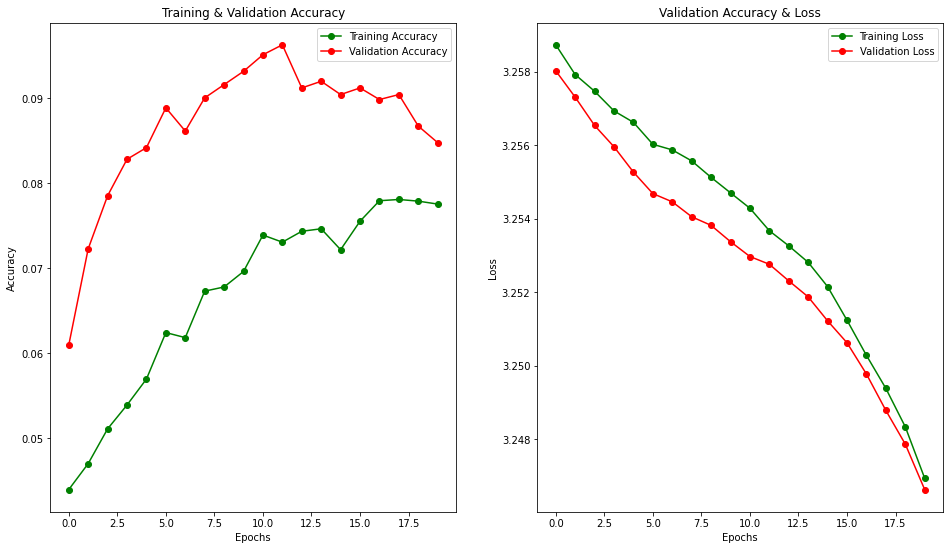

In [15]:
list_epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = baseline_history.history['accuracy']
train_loss = baseline_history.history['loss']
val_acc = baseline_history.history['val_accuracy']
val_loss = baseline_history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(list_epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(list_epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(list_epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(list_epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Validation Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [16]:
score =  baseline_model.evaluate(validation_generator, steps=val_steps)
print('Loss: ', score[0])
print('Accuracy: ', score[1])

10/10 [==============================] - 7s 661ms/step - loss: 3.2466 - accuracy: 0.0846
Loss:  3.246601104736328
Accuracy:  0.08457031100988388


# **d. Arsitektur hasil tuning**

Untuk tuning arsitektur, saya menambahkan dropout dan batch normalization

Arsitektur NN pada code ini cukup dalam (deep) sehingga cukup rentan terhadap overfitting

Maka, teknik dropout diterapkan untuk meminimalisir efek dari overfitting. Dropout dilakukan dengan mengurangi jumlah interconnecting neurons secara acak (berdasarkan probability yang ditentukan) dalam neural network. Berdasarkan sebuah studi (https://arxiv.org/pdf/1207.0580.pdf), penggunaan dropout pada setiap layer menunjukkan improvement yang cukup signifikan terhadap performa model

Jadi, untuk penerapan dropout pada modified model ini, saya mencoba berbagai nilai dropout, hasil terbaik didapatkan oleh p = 0.1

Kemudian, batch normalization juga dilakukan untuk menerapkan normalisasi input. Hal ini dapat mempercepat proses training model dan juga meningkatkan performa dari model.

Dari sumber-sumber yang saya baca, untuk CNN lebih baik batch normalization ditempatkan antara Convolution dan MaxPooling, serta sebelum dropout

In [64]:
n_features = 64
dropout_p = 0.1

In [65]:
modified_model = tf.keras.Sequential()

# Conv2D pertama + activation relu
modified_model.add(tf.keras.layers.Conv2D(n_features, first_kernel_size, input_shape=[resized_dim, resized_dim, 1], padding='same', activation='relu'))
# MaxPooling2D pertama
modified_model.add(tf.keras.layers.BatchNormalization())
modified_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
modified_model.add(tf.keras.layers.Dropout(dropout_p))
n_features /= 2 # Bagi n_features dengan 2

# Conv2D kedua + activation relu
modified_model.add(tf.keras.layers.Conv2D(n_features, second_kernel_size, padding='same', activation='relu'))
modified_model.add(tf.keras.layers.BatchNormalization())
# MaxPooling2D kedua
modified_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
modified_model.add(tf.keras.layers.Dropout(dropout_p))
n_features /= 2

# Conv2D ketiga + activation relu
modified_model.add(tf.keras.layers.Conv2D(n_features, second_kernel_size, activation='relu'))
modified_model.add(tf.keras.layers.BatchNormalization())
# MaxPooling2D ketiga
modified_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
modified_model.add(tf.keras.layers.Dropout(dropout_p))

# Flatten
modified_model.add(tf.keras.layers.Flatten())

# Dense
modified_model.add(tf.keras.layers.Dense(32, activation='relu'))
modified_model.add(tf.keras.layers.Dropout(dropout_p))
modified_model.add(tf.keras.layers.Dense(nb_classes, activation='softmax'))

Untuk tuning, saya mencoba menggunakan optimizer adam karena optimizer adam dipercaya sebagai optimizer yang paling baik untuk classification saat ini (terutama karena NN yang digunakan juga cukup dalam/deep)

Learning rate yang saya gunakan adalah 0.01

In [66]:
optim = tf.keras.optimizers.Adam(learning_rate=0.01)
modified_model.compile(optimizer = optim , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
modified_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 64, 64, 64)        1664      
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 32)     

**Train modified model**

In [67]:
modified_history = modified_model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator, 
    validation_steps = val_steps,
    epochs = epochs
  )

Epoch 1/20
40/40 [==============================] - 101s 2s/step - loss: 2.2652 - accuracy: 0.2910 - val_loss: 26.9083 - val_accuracy: 0.0385
Epoch 2/20
40/40 [==============================] - 99s 2s/step - loss: 1.1354 - accuracy: 0.5973 - val_loss: 10.9102 - val_accuracy: 0.0648
Epoch 3/20
40/40 [==============================] - 97s 2s/step - loss: 0.7682 - accuracy: 0.7288 - val_loss: 7.1003 - val_accuracy: 0.0777
Epoch 4/20
40/40 [==============================] - 89s 2s/step - loss: 0.5537 - accuracy: 0.8065 - val_loss: 11.4408 - val_accuracy: 0.1078
Epoch 5/20
40/40 [==============================] - 90s 2s/step - loss: 0.4374 - accuracy: 0.8426 - val_loss: 13.3244 - val_accuracy: 0.1367
Epoch 6/20
40/40 [==============================] - 92s 2s/step - loss: 0.3367 - accuracy: 0.8808 - val_loss: 18.0154 - val_accuracy: 0.1625
Epoch 7/20
40/40 [==============================] - 117s 3s/step - loss: 0.2857 - accuracy: 0.9008 - val_loss: 13.4999 - val_accuracy: 0.1664
Epoch 8/20
4

**Evaluate modified model**

In [68]:
new_score =  modified_model.evaluate(validation_generator, steps=val_steps)
print('Loss: ', new_score[0])
print('Accuracy: ', new_score[1])

10/10 [==============================] - 10s 997ms/step - loss: 0.6703 - accuracy: 0.8406
Loss:  0.6702698469161987
Accuracy:  0.840624988079071


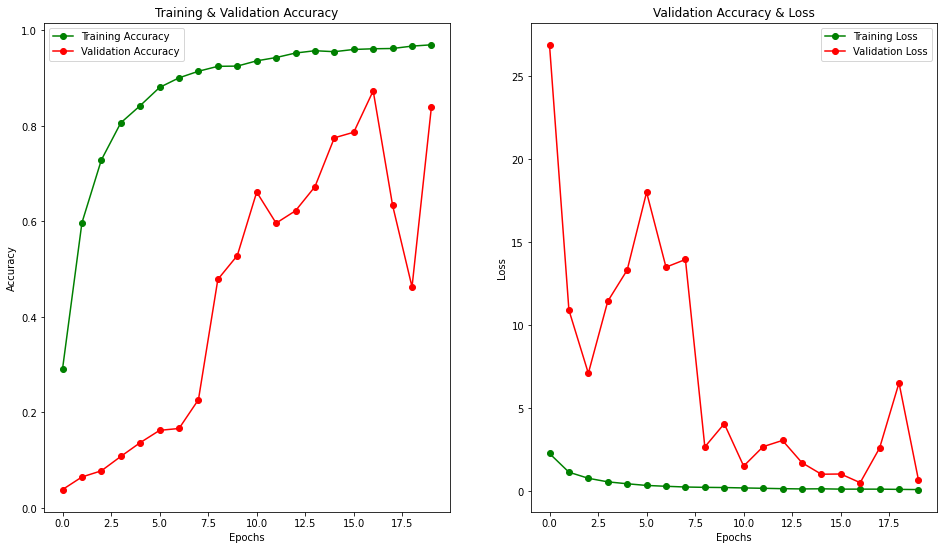

In [69]:
fig , ax = plt.subplots(1,2)
train_acc = modified_history.history['accuracy']
train_loss = modified_history.history['loss']
val_acc = modified_history.history['val_accuracy']
val_loss = modified_history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(list_epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(list_epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(list_epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(list_epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Validation Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

**Evaluate hasil testing**

In [70]:
test_generator.reset()

pred=modified_model.predict(
    test_generator,
    steps=test_steps,
    verbose=1
  )

28/28 [==============================] - 2s 11ms/step


In [71]:
predicted_class_indices = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(predictions)

ground_truth = true_classes
print(ground_truth)

['L', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'M', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'Y', 'Z', 'A', 'Z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'nothing', 'N', 'O', 'P', 'Q', 'R', 'space', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
